# Don't Overfit

One of the main objectives of predictive modelling is to build a model that will give accurate predictions on unseen data.

A necessary step in the building of models is to ensure that they have not overfit the training data, which leads to sub optimal predictions on new data.

The purpose of this challenge is to stimulate research and highlight existing algorithms, techniques or strategies that can be used to guard against overfitting.

## Objective
The objective is to score greater than 0.8 in leader board

In [80]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  plot_roc_curve, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from math import ceil
from sklearn.tree import DecisionTreeClassifier
import warnings
import scipy
import scipy.stats
warnings.filterwarnings('ignore')

RANDOM_STATE = 0

In [81]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

## Data Background

- The train set has 250 observation and 301 features with no missing value.
- The features are of float datatypes
- The observation has no duplicate value
- The standard deviation for train_set is between 0.8 and 1.125 while mean is between -0.20 and 0.2
- The min and max values of trainset +/- -0.425 and  +/- 3.8 respectively.

Therefore, it can be concluded that the train and test dataset are from the same distribution/population

In [82]:
train.shape

(250, 302)

In [83]:
train.isnull().values.any()

False

In [84]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Columns: 302 entries, id to 299
dtypes: float64(301), int64(1)
memory usage: 590.0 KB


In [85]:
train.duplicated().sum()

0

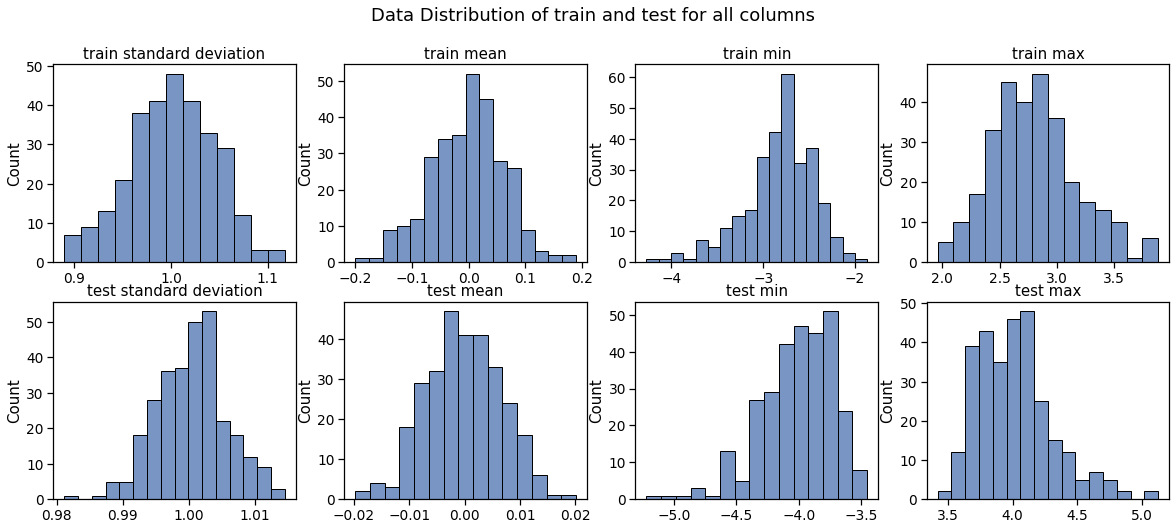

In [96]:
fig, axes = plt.subplots(2, 4, figsize = (20,8))
fig.suptitle('Data Distribution of train and test for all columns')
axes[0,0].set_title('train standard deviation')
sns.histplot(  data=train[train.columns[2:]].std() , ax=axes[0,0])
axes[0,1].set_title('train mean')
sns.histplot(data=train[train.columns[2:]].mean(), ax=axes[0,1])
axes[0,2].set_title('train min')
sns.histplot(data=train[train.columns[2:]].min(), ax = axes[0,2])
axes[0,3].set_title('train max')
sns.histplot(data=train[train.columns[2:]].max(), ax = axes[0,3])

axes[1,0].set_title('test standard deviation')
sns.histplot(  data=test[test.columns[2:]].std(), ax=axes[1,0])
axes[1,1].set_title('test mean')
sns.histplot(data=test[test.columns[2:]].mean(), ax=axes[1,1])
axes[1,2].set_title('test min')
sns.histplot(data=test[test.columns[2:]].min(), ax = axes[1,2])
axes[1,3].set_title('test max')
sns.histplot(data=test[test.columns[2:]].max(), ax = axes[1,3]);

## Skewness
To review the skewness: 
1. Random features will be selected and visualized
2. Skewness will be computed

The result showed that the data assumes a binomial distribution

In [87]:
pd.cut(train.skew(), bins=5).value_counts()

(-0.179, 0.0252]    133
(0.0252, 0.229]     113
(-0.383, -0.179]     37
(0.229, 0.433]       18
(-0.588, -0.383]      1
dtype: int64

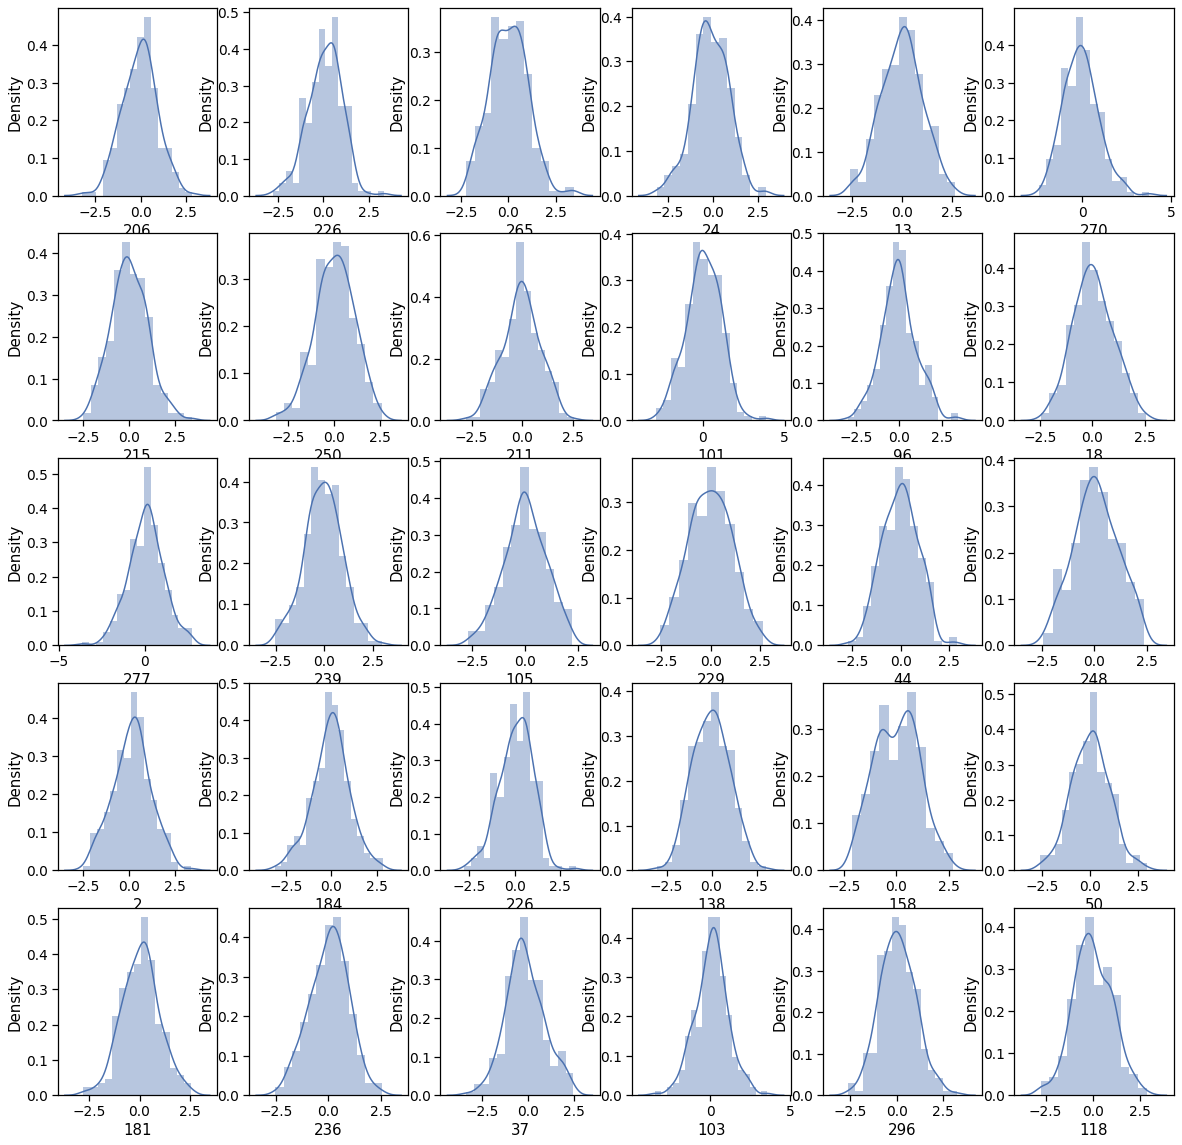

In [88]:
num = 30
r = np.random.randint(0,299,num,dtype=int)

n_cols = 6
n_rows = ceil(num/n_cols)
counter = 1

fig = plt.figure(figsize=(20,20))
for col in range(num):
    plt.subplot(n_rows, n_cols, counter)
    plt.xlabel(f"{col} feature")
    g = sns.distplot(train[str(r[col])])
    
    counter += 1

plt.show();

## Outliers

Boxplot is used to visualize the mean distribution of train dataset

The visualization showed that the distribution of the train dataset are close and have similar mean

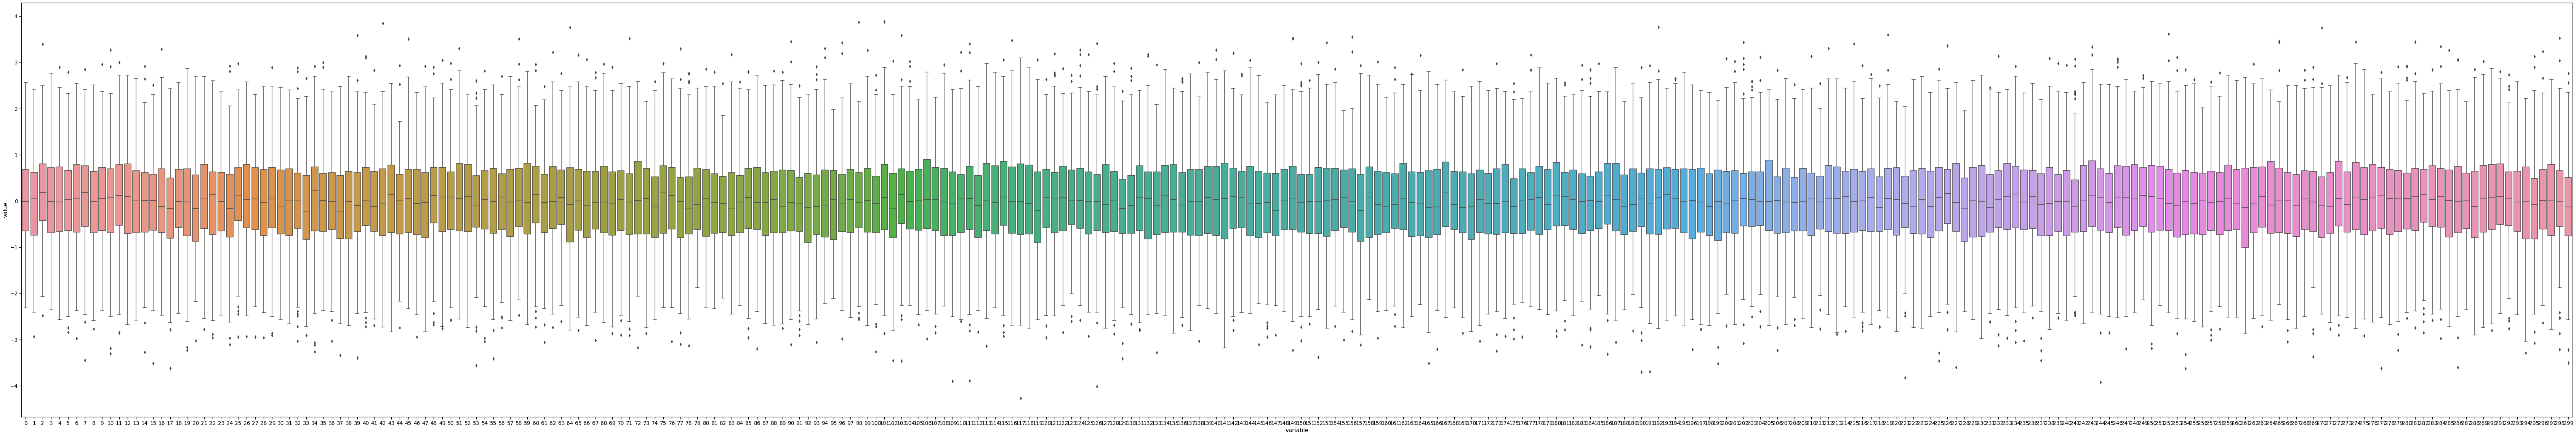

In [89]:
fig = plt.figure(figsize=(120,20))
sns.boxplot(x="variable", y="value", data=pd.melt(train.drop(columns=['id', 'target'])))

plt.show()

## Correlation
reviewing the correlations showed that features correlation with target ranges from +0.37 to -0.2

Also, the features do not have strong correlation with each other considering the population of 250. Therefore, it can be assumed that colinearity doesnt exist in the dataset

In [90]:
corr_matrix = train.corr()

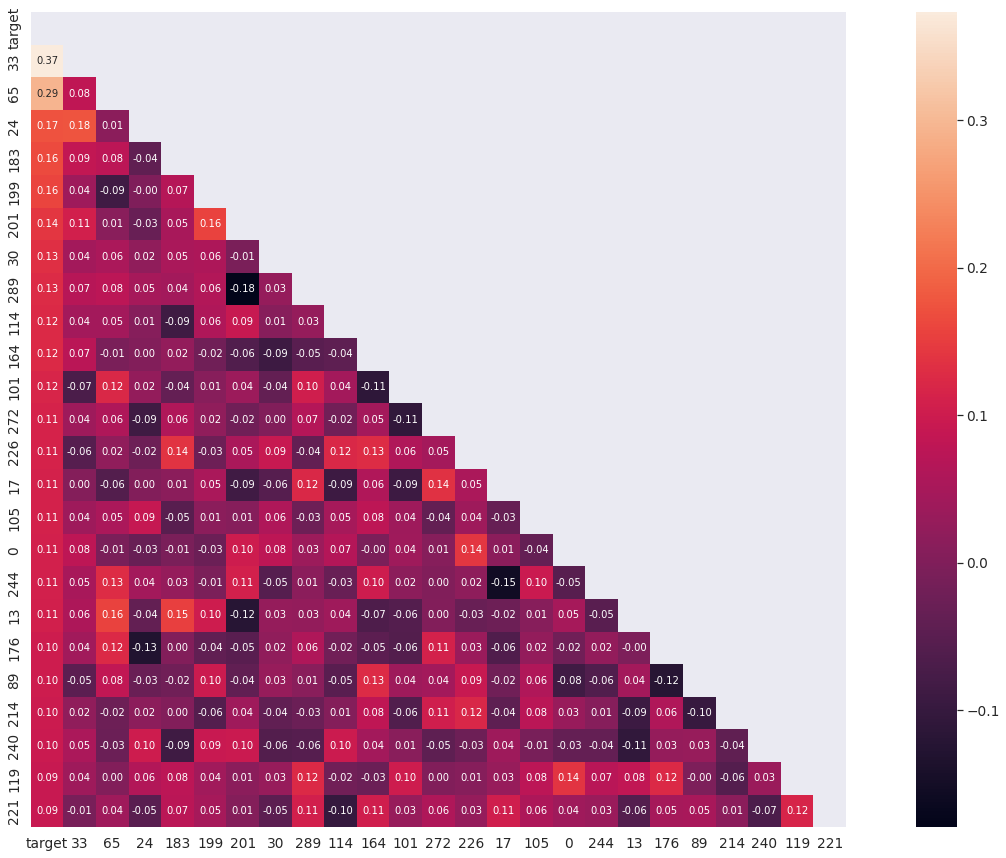

In [91]:
corr_cols = corr_matrix.nlargest(25, 'target')['target'].index
cm = np.corrcoef(train[corr_cols].values.T)
mask = np.zeros_like(cm)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig = plt.figure(figsize=(25,15))
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, mask=mask, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corr_cols.values, xticklabels=corr_cols.values)
plt.show()

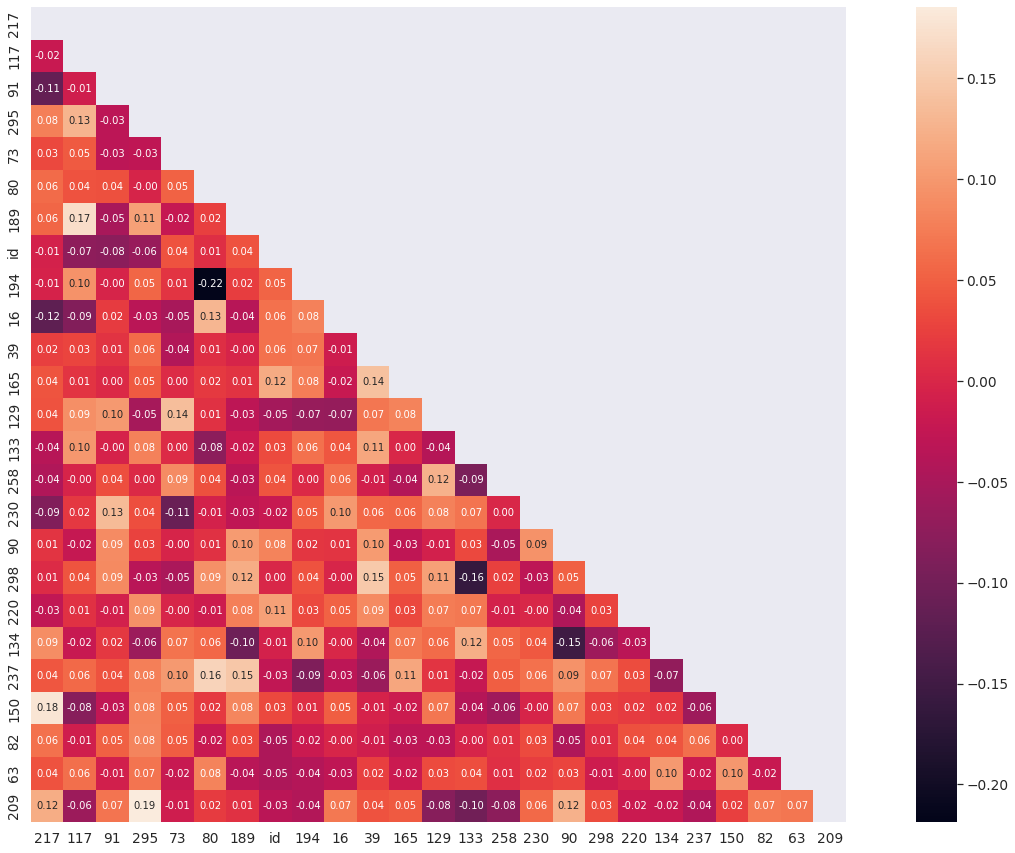

In [92]:
corr_cols = corr_matrix.nsmallest(25, 'target')['target'].index
cm = np.corrcoef(train[corr_cols].values.T)
mask = np.zeros_like(cm)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig = plt.figure(figsize=(25,15))
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, mask=mask, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corr_cols.values, xticklabels=corr_cols.values)
plt.show()

## Target 

The dataset target is imbalanced. 2/3 of the target belong to class 1

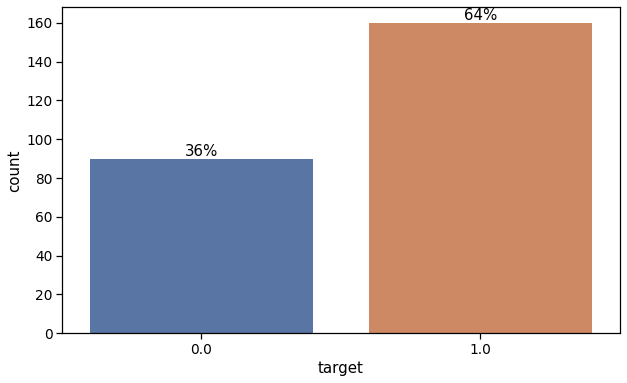

In [93]:
fig = plt.figure(figsize=(10,6))
g = sns.countplot(train['target'])
for p in g.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    g.annotate('{:.2g}%'.format(100.*y/len(train['target'])), (x.mean(), y), ha='center', va='bottom')

# Preprocessing

In [94]:
target = train['target']
test_Id = test['id']
train = train.drop(columns=['target', 'id'])
train_columns = train.columns
test = test.drop(columns = 'id')

In [75]:
std_scaler = StandardScaler()
std_scaler.fit(train)
train = std_scaler.transform(train)
test = std_scaler.transform(test)

# Model

Since goal of the project is to achieve a score greater than 0.8 on the public board while avaoiding overfitting, cross validation is done for classifiers and the best result is used for the test result.

In [76]:
models = [
          ('LogReg', LogisticRegression(C=0.1, class_weight='balanced',  max_iter=10000,
                    penalty='l1', solver='liblinear')), 
          ('RF', RandomForestClassifier(class_weight='balanced', n_estimators =  1000, max_depth = 5, max_features = 0.9, min_samples_split = 8
          )),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('GB', GradientBoostingClassifier(criterion="mse", learning_rate=0.1, max_depth=5, max_features=0.1, min_samples_split=2, n_estimators=1000)),
          ('DT', DecisionTreeClassifier(class_weight="balanced"))
        ]
dfs = []
results = []
names = []
scoring = ['f1_weighted', 'roc_auc']

for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    cv_results = cross_validate(model, train, target, cv=kfold, scoring=scoring, return_train_score=True)
    results.append(cv_results)
    names.append(name)
    
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)

In [77]:
result = final.groupby(['model']).agg({'test_f1_weighted':'mean', 'train_f1_weighted':'mean', 'test_roc_auc':'mean', 'train_roc_auc':'mean' }).reset_index()
result['auc_diff'] = result['train_roc_auc'] - result['test_roc_auc']
result.sort_values(by='auc_diff')

,model,test_f1_weighted,train_f1_weighted,test_roc_auc,train_roc_auc,auc_diff
4,LogReg,0.685842,0.871790,0.808351,0.955697,0.147346
3,KNN,0.574395,0.760121,0.553725,0.800663,0.246938
6,SVM,0.519071,1.000000,0.747949,1.000000,0.252051
5,RF,0.695212,1.000000,0.747924,1.000000,0.252076
2,GNB,0.701676,0.982249,0.736182,0.998591,0.262409
1,GB,0.667727,1.000000,0.732986,1.000000,0.267014
0,DT,0.599841,1.000000,0.575295,1.000000,0.424705


## Selected Model

Based on the cross validation result, Logistic Regression will be used for the result.

Logistic Regression performed better than the others fairly because the dataset isnt complex and has a simple pattern

For Logistic Regression, feature importance is also viewed since the features are fairly correlated to the target

In [78]:
logistic = LogisticRegression(C=0.1, class_weight='balanced',  max_iter=10000,
                    penalty='l1', random_state=RANDOM_STATE, solver='liblinear'
                   )
logistic.fit(train, target)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=10000, penalty='l1',
                   random_state=0, solver='liblinear')

In [95]:
importances = pd.DataFrame(data={
    'Attribute': train_columns,
    'Importance': logistic.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
importances

,Attribute,Importance
33,33,0.680527
65,65,0.473230
199,199,0.222471
226,226,0.050798
101,101,0.049416
...,...,...
295,295,-0.139030
73,73,-0.181076
117,117,-0.194949
91,91,-0.259552


In [ ]:
logistic_pred = logistic.predict(test)

In [ ]:
probs = logistic.predict_proba(test)

In [ ]:
output = pd.DataFrame(
    {
        'id': test_Id,
        'target': probs[:,1]
    })
output.to_csv('output.csv', index=False)

# Conclusion

The Logistic Regression output generated a result of 0.84 which meets the goal. 
Also the model didnt overfit:
1. The result of train and test cross validation AUC are close. 0.808351 and 0.955697 for test and train respectively
2. Penalization of L1 used